Mapping Heat Exposure × Pedestrian Activity in Midtown Manhattan

In [31]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [32]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [33]:
def find_summer_pm_columns(df):
    all_columns = df.columns.tolist()
    summer_pm_columns = []
    for col in all_columns:
        col_lower = col.lower()
        if any(month in col_lower for month in ["june", "july", "august", "summer"]):
            if any(
                pm_ind in col_lower for pm_ind in ["pm", "afternoon", "evening", "late"]
            ):
                summer_pm_columns.append(col)
    if not summer_pm_columns:
        pm_columns = [
            col
            for col in all_columns
            if "pm" in col.lower()
            or "afternoon" in col.lower()
            or "evening" in col.lower()
        ]
        summer_pm_columns = pm_columns
    return summer_pm_columns

In [34]:
def calculate_summer_pm_counts(df, summer_pm_columns):
    if summer_pm_columns:
        numeric_cols = []
        for col in summer_pm_columns:
            try:
                pd.to_numeric(df[col], errors="coerce")
                numeric_cols.append(col)
            except:
                continue
        if numeric_cols:
            df["summer_pm_count"] = df[numeric_cols].mean(axis=1)
        else:
            df["summer_pm_count"] = 0
    else:
        df["summer_pm_count"] = 0
    return df

In [35]:
ped_df = pd.read_csv(
    "/Users/sunni/Desktop/GitHub/CDP-Mapping-Systems/Data/Bi-Annual_Pedestrian_Counts_20250709.csv"
)
temp_df = pd.read_csv(
    "/Users/sunni/Desktop/GitHub/CDP-Mapping-Systems/Data/Hyperlocal_Temperature_Monitoring_20250709.csv"
)
mappluto_gdf = gpd.read_file(
    "/Users/sunni/Desktop/GitHub/CDP-Mapping-Systems/Data/nyc_mappluto_25v2_shp"
)

In [37]:
manhattan_gdf = mappluto_gdf[mappluto_gdf["Borough"] == "MN"].copy()
manhattan_gdf = manhattan_gdf.to_crs(epsg=4326)

In [38]:
ped_manhattan = ped_df[ped_df["Borough"].str.lower() == "manhattan"].copy()

In [ ]:
summer_pm_cols = find_summer_pm_columns(ped_manhattan)
ped_manhattan = calculate_summer_pm_counts(ped_manhattan, summer_pm_cols)

In [40]:
ped_manhattan.columns

Index(['the_geom', 'OBJECTID', 'Loc', 'Borough', 'Street_Nam', 'From_Stree',
       'To_Street', 'Iex', 'May07_AM', 'May07_PM',
       ...
       'Oct23_AM', 'Oct23_PM', 'Oct23_MD', 'June24_AM', 'June24_PM',
       'June24_MD', 'Oct24_AM', 'Oct24_PM', 'Oct24_MD', 'summer_pm_count'],
      dtype='object', length=111)

In [41]:
print(ped_manhattan["the_geom"].head())

34     POINT (-74.01155687409947 40.70463665187375)
35     POINT (-74.01286204592034 40.70634164448271)
36      POINT (-73.98219706247882 40.7718134030119)
37    POINT (-74.01009312926121 40.715904559004244)
38     POINT (-73.97713579908014 40.77968082763136)
Name: the_geom, dtype: object


In [48]:
from shapely import wkt

ped_manhattan["geometry"] = ped_manhattan["the_geom"].apply(wkt.loads)
ped_gdf = gpd.GeoDataFrame(ped_manhattan, geometry="geometry", crs="EPSG:4326")

In [49]:
temp_df.columns

Index(['Sensor.ID', 'AirTemp', 'Day', 'Hour', 'Latitude', 'Longitude', 'Year',
       'Install.Type', 'Borough', 'ntacode', 'Datetime'],
      dtype='object')

In [50]:
temp_df["Day"] = pd.to_datetime(temp_df["Day"])
temp_df["Hour"] = temp_df["Day"].dt.hour
heat_window = temp_df[(temp_df["Hour"] >= 15) & (temp_df["Hour"] <= 18)]

avg_temp = (
    heat_window.groupby(["Sensor.ID", "Latitude", "Longitude"])["AirTemp"]
    .mean()
    .reset_index()
)

In [51]:
temp_gdf = gpd.GeoDataFrame(
    avg_temp,
    geometry=gpd.points_from_xy(avg_temp.Longitude, avg_temp.Latitude),
    crs="EPSG:4326",
)

In [52]:
ped_gdf = ped_gdf.to_crs(epsg=3857)
temp_gdf = temp_gdf.to_crs(epsg=3857)
manhattan_gdf = manhattan_gdf.to_crs(epsg=3857)

In [53]:
ped_gdf = gpd.sjoin(
    ped_gdf, manhattan_gdf[["geometry"]], how="inner", predicate="within"
)
temp_gdf = gpd.sjoin(
    temp_gdf, manhattan_gdf[["geometry"]], how="inner", predicate="within"
)

In [60]:
print(temp_gdf.columns)

Index(['Sensor.ID', 'Latitude', 'Longitude', 'AirTemp', 'geometry',
       'index_right'],
      dtype='object')


In [65]:
if "index_right" in temp_gdf.columns:
    temp_gdf = temp_gdf.drop(columns=["index_right"])

In [66]:
print(temp_gdf.columns)

Index(['Sensor.ID', 'Latitude', 'Longitude', 'AirTemp', 'geometry'], dtype='object')


In [68]:
print("ped_gdf columns:", ped_gdf.columns.tolist())
print("temp_gdf columns:", temp_gdf.columns.tolist())

ped_gdf columns: ['the_geom', 'OBJECTID', 'Loc', 'Borough', 'Street_Nam', 'From_Stree', 'To_Street', 'Iex', 'May07_AM', 'May07_PM', 'May07_MD', 'Sept07_AM', 'Sept07_PM', 'Sept07_MD', 'May08_AM', 'May08_PM', 'May08_MD', 'Sept08_AM', 'Sept08_PM', 'Sept08_MD', 'May09_AM', 'May09_PM', 'May09_MD', 'Sept09_AM', 'Sept09_PM', 'Sept09_MD', 'May10_AM', 'May10_PM', 'May10_MD', 'Sept10_AM', 'Sept10_PM', 'Sept10_MD', 'May11_AM', 'May11_PM', 'May11_MD', 'Sept11_AM', 'Sept11_PM', 'Sept11_MD', 'May12_AM', 'May12_PM', 'May12_MD', 'Sept12_AM', 'Sept12_PM', 'Sept12_MD', 'May13_AM', 'May13_PM', 'May13_MD', 'Sept13_AM', 'Sept13_PM', 'Sept13_MD', 'May14_AM', 'May14_PM', 'May14_MD', 'Sept14_AM', 'Sept14_PM', 'Sept14_MD', 'May15_AM', 'May15_PM', 'May15_MD', 'Sept15_AM', 'Sept15_PM', 'Sept15_MD', 'May16_AM', 'May16_PM', 'May16_MD', 'Sept16_AM', 'Sept16_PM', 'Sept16_MD', 'May17_AM', 'May17_PM', 'May17_MD', 'Sept17_AM', 'Sept17_PM', 'Sept17_MD', 'May18_AM', 'May18_PM', 'May18_MD', 'Sept18_AM', 'Sept18_PM', 'Sept

In [69]:
for df in [ped_gdf, temp_gdf]:
    for col in ["index_right", "index_left", "index"]:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
ped_gdf = ped_gdf.reset_index(drop=True)
temp_gdf = temp_gdf.reset_index(drop=True)

In [70]:
joined = gpd.sjoin_nearest(
    ped_gdf, temp_gdf[["geometry", "AirTemp"]], how="left", max_distance=200
)

In [71]:
joined["Exposure_Index"] = joined["summer_pm_count"] * joined["AirTemp"]

In [73]:
print(joined.shape)
print(joined.head())
print(joined["Exposure_Index"].describe())
print(joined["geometry"].is_empty.sum())

(1, 115)
                                      the_geom  OBJECTID  Loc    Borough  \
0  POINT (-73.99694382805035 40.7673124325193)        70   70  Manhattan   

              Street_Nam   From_Stree    To_Street Iex  May07_AM  May07_PM  \
0  Hudson River Greenway  50th Street  51st Street   N       190       382   

   ...  June24_PM  June24_MD  Oct24_AM  Oct24_PM  Oct24_MD  summer_pm_count  \
0  ...        729        380       683       951     990.0            729.0   

                           geometry  index_right  AirTemp  Exposure_Index  
0  POINT (-8237302.107 4978080.647)          NaN      NaN             NaN  

[1 rows x 115 columns]
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Exposure_Index, dtype: float64
0


In [74]:
print(joined["summer_pm_count"].describe())
print(joined["AirTemp"].describe())

count      1.0
mean     729.0
std        NaN
min      729.0
25%      729.0
50%      729.0
75%      729.0
max      729.0
Name: summer_pm_count, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: AirTemp, dtype: float64


In [76]:
print(ped_gdf.crs)
print(temp_gdf.crs)

EPSG:3857
EPSG:3857


In [77]:
joined = gpd.sjoin_nearest(
    ped_gdf, temp_gdf[["geometry", "AirTemp"]], how="left", max_distance=500  # 或更大
)

In [79]:
print(joined.shape)
print(joined["AirTemp"].notnull().sum())

(1, 114)
0


KeyError: 'Exposure_Index'

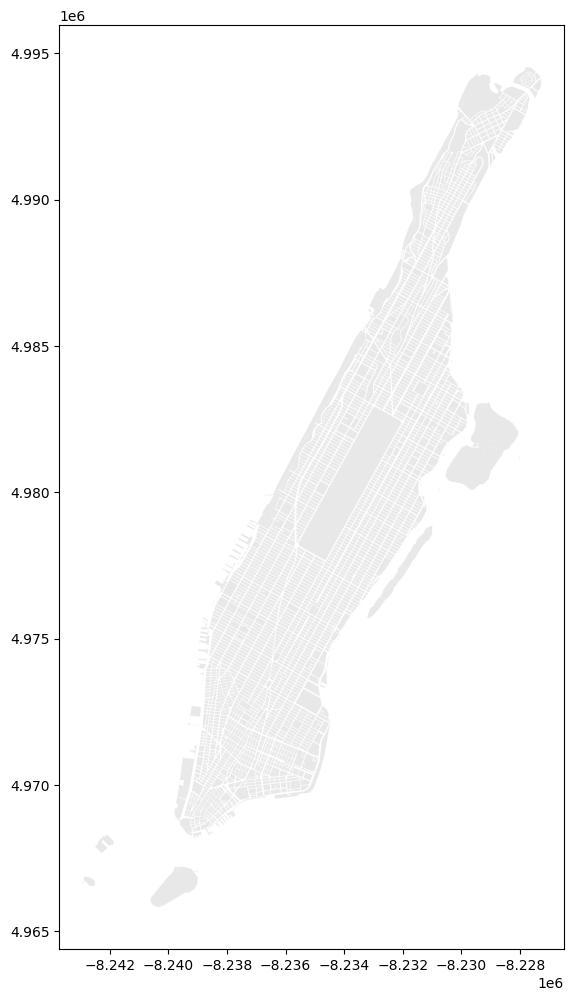

In [78]:
fig, ax = plt.subplots(figsize=(12, 12))
manhattan_gdf.plot(ax=ax, color="lightgrey", alpha=0.5)
joined.plot(
    column="Exposure_Index", ax=ax, cmap="Reds", legend=True, markersize=40, alpha=0.7
)
plt.title("Manhattan Heat Exposure × Pedestrian Volume (3-6PM Summer)")
plt.axis("off")
plt.show()